#01.SETUP

In [2]:
import os

In [3]:
cd /root/Share/LOTUSROOM/lotusroom_notebooks

/root/Share/LOTUSROOM/lotusroom_notebooks


In [4]:
!pip install transformers==4.25.1
!pip install bitsandbytes-cuda111==0.26.0
!pip install datasets==1.16.1
!pip install bitsandbytes loguru
!pip install discord.py
!pip install diffusers --upgrade
!pip install invisible_watermark transformers accelerate safetensors
!pip install transformers --upgrade
!pip install langdetect
!pip install scipy
!pip install tensorboard
!pip install ctranslate2 sentencepiece
!pip install -q diffusers transformers accelerate peft
!pip install googletrans==4.0.0-rc1

  Using cached transformers-4.25.1-py3-none-any.whl.metadata (93 kB)
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.25.1-py3-none-any.whl (5.8 MB)
Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.2
    Uninstalling tr

In [5]:
import os
from config._tokens import *
os.environ['TOKEN1'] = token1
os.environ['TOKEN2'] = token2
os.environ['TOKEN3'] = token3

#02.LOAD GPTs & SD

In [6]:
from gptj import config, tokenizer, GPTJForCausalLM
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#gpt = GPTJForCausalLM.from_pretrained("./saved_models_gpt-j-6B-8bit/gpt-j-6B",low_cpu_mem_usage=True)
gpt = GPTJForCausalLM.from_pretrained("/root/Share/LOTUSROOM/mary-shelly", revision="float16", torch_dtype=torch.float32, low_cpu_mem_usage=True)
gpt.to(device)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


lm_head Linear(in_features=4096, out_features=50400, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, b

Some weights of the model checkpoint at /root/Share/LOTUSROOM/mary-shelly were not used when initializing GPTJForCausalLM: ['lm_head.adapter.0.weight', 'lm_head.adapter.1.weight', 'transformer.h.0.attn.k_proj.adapter.0.weight', 'transformer.h.0.attn.k_proj.adapter.1.weight', 'transformer.h.0.attn.out_proj.adapter.0.weight', 'transformer.h.0.attn.out_proj.adapter.1.weight', 'transformer.h.0.attn.q_proj.adapter.0.weight', 'transformer.h.0.attn.q_proj.adapter.1.weight', 'transformer.h.0.attn.v_proj.adapter.0.weight', 'transformer.h.0.attn.v_proj.adapter.1.weight', 'transformer.h.0.mlp.fc_in.adapter.0.weight', 'transformer.h.0.mlp.fc_in.adapter.1.weight', 'transformer.h.0.mlp.fc_out.adapter.0.weight', 'transformer.h.0.mlp.fc_out.adapter.1.weight', 'transformer.h.1.attn.k_proj.adapter.0.weight', 'transformer.h.1.attn.k_proj.adapter.1.weight', 'transformer.h.1.attn.out_proj.adapter.0.weight', 'transformer.h.1.attn.out_proj.adapter.1.weight', 'transformer.h.1.attn.q_proj.adapter.0.weight', 't

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-27): 28 x GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): FrozenBNBLinear(4096, 50400)
)

In [7]:
async def get_mary_response(prompt, min_words=128, max_words=128):
    global device, tokenizer, gpt
    prompt = tokenizer(prompt, return_tensors='pt')
    prompt = {key: value.to(device) for key, value in prompt.items()}
    out = gpt.generate(**prompt, min_length=min_words, max_length=max_words, do_sample=True)
    return tokenizer.decode(out[0])

In [8]:
from diffusers import AutoPipelineForImage2Image

#pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")
pipe = AutoPipelineForImage2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda:1")
pipe.load_lora_weights("/root/Share/LOTUSROOM/LoRA/diaphanera.safetensors", adapter_name="diaphanera")
pipe.set_adapters(["diaphanera"], adapter_weights=[1.0])




Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]


In [9]:
from PIL import Image
init_image = Image.open("/root/Share/LOTUSROOM/ref/HR_0266.jpg").resize((900,900))

negative_prompt = "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
seed=0
generator = torch.manual_seed(seed)


In [10]:
import random
prompt_list=['a piece of agate with a red and white pattern', 'a large piece of blue and white marble', 'a piece of agate with a blue and yellow pattern', 'a large piece of agate with a very large center', 'a piece of agate with a red and white stripe', 'a green and white stone with a black background', 'a large piece of pink and white rock', 'a piece of yellow agate with black spots', 'a piece of white and gold marble with a triangle', 'a piece of red and green agate', 'a large piece of agate with a diamond in the center', 'a large piece of red and black agate', 'a piece of rock with a hole in it', 'a white vase with a green center on a black surface', 'a green and yellow stone with a black background', 'a piece of agate with a black and white pattern', 'a piece of rock with a very large piece of rock in the middle', 'a piece of rock with a very colorful pattern', 'a piece of agate with a pattern of swirls', 'a piece of agate with a face on it', 'a large piece of art with a very colorful design', 'a piece of rock with a piece of rock in it', 'a piece of agate with a hole in it', 'a large piece of rock with a very large center', 'a piece of rock with a black and white pattern', 'a blue and white piece of rock with water inside', 'a piece of agate with a yellow and white swirl', 'a piece of rock with a white object in it', 'a picture of a lake with a sky in the background', 'a piece of agate with a black bird on it', 'a piece of agate with a pattern of swirls', 'a large piece of red and white rock with a black hole', 'a piece of rock with a very large piece of rock', 'a piece of red and white rock with a black background', 'a large piece of rock with a large crystal in it', 'a piece of agate with a red and white stripe', 'a slice of agate with a black background', 'a large piece of agate with a white and blue pattern', 'a slice of agate with a red and yellow stripe', 'a piece of rock with a cross on it', 'a slice of agate with a red center', 'a large piece of white and brown agate', 'a large slice of agate with a face on it', 'a piece of rock with a very large piece of material']
base_prompt = "((((diaphanera)))), ((("+ random.choice(prompt_list) +")))"
print (base_prompt)

((((diaphanera)))), (((a piece of rock with a very large piece of material)))


In [11]:
def generate_sd(prompt):
    with torch.no_grad():  # 勾配計算を無効化
        base_prompt = f"diaphanera, {random.choice(prompt_list)}"
        print (base_prompt+prompt)
        image = pipe(
            prompt=f"{base_prompt}, ((({prompt})))",
            width=894,
            height=894,
            image=init_image,
            negative_prompt=negative_prompt,
            generator=generator,
            strength=0.63,
            guidance_scale=7.0,
            num_inference_steps=20).images[0]
    return image

diaphanera, a large piece of white and brown agate


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]


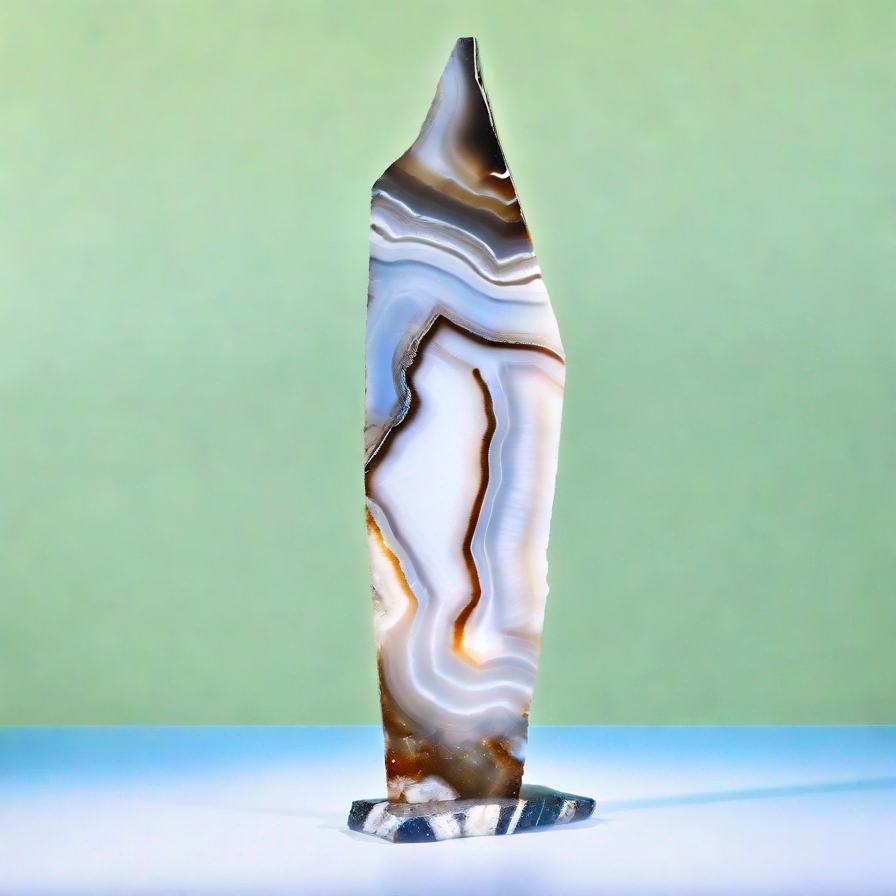

In [12]:
prompt=''
generate_sd(prompt)

In [13]:
#!pip install openai --upgrade
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install openai==0.28

# 2. APIキーを設定
import openai
import os

from config._api_key import openai_api
openai.api_key = openai_api
os.environ['OPENAI_API'] = openai_api

async def get_gpt4_response(prompt, model="gpt-4-0125-preview", tokens=1000):
    response = await openai.ChatCompletion.acreate(
        model=model,
        messages=[
            {"role": "system", "content": "You are a brilliant fashion design assistant."},
            {"role": "user", "content": prompt},
        ],
        max_tokens=tokens,
        temperature=0.7,
    )
    return response




DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [14]:
prompt='eureka'
await get_mary_response(prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'eureka.instance.hostName" value="#settings.eureka.instance.url"/>\n        </entry>\n        <entry key="eureka.instance.nonCoreServicesPort">\n            <value>8091</value>\n        </entry>\n        <entry key="eureka.instance.statusPagePath">\n            <value>/actuator/'

In [15]:
await get_gpt4_response(prompt)

<OpenAIObject chat.completion id=chatcmpl-8uaictfBDZyYhn9KEYFOfG4NChjS0 at 0x7f0696f3ea70> JSON: {
  "id": "chatcmpl-8uaictfBDZyYhn9KEYFOfG4NChjS0",
  "object": "chat.completion",
  "created": 1708498206,
  "model": "gpt-4-0125-preview",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "It sounds like you've had a moment of inspiration or a breakthrough idea! How fantastic! How can I assist you in turning your \"Eureka\" moment into a tangible fashion concept or design? Whether you need help refining your idea, sketching it out, selecting fabrics, or understanding how to construct it, I'm here to help. Let's dive into the details of your vision!"
      },
      "logprobs": null,
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 21,
    "completion_tokens": 78,
    "total_tokens": 99
  },
  "system_fingerprint": "fp_f084bcfc79"
}

# 03.LOAD LOTUS

In [16]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('discord')
logger.setLevel(logging.ERROR)
handler = logging.FileHandler(filename='discord.log', encoding='utf-8', mode='w')
handler.setFormatter(logging.Formatter('%(asctime)s:%(levelname)s:%(name)s: %(message)s'))
logger.addHandler(handler)

In [17]:
from config.prompts import *

In [18]:
import discord
import os
import openai
import asyncio
import re
from datetime import datetime
import shutil
from asyncio import sleep
import random

from langdetect import detect as lang_detect
from langdetect import LangDetectException

from googletrans import Translator

BG_EXT = ".gif"
BG_GIF_PATH = f'/root/Share/LOTUSROOM/GDrive/3dlogo_typ_bg{BG_EXT}'

#initial
intents = discord.Intents.default()
intents.message_content = True
client_gpt = discord.Client(intents=intents)
client_mary = discord.Client(intents=intents)

token_mary = os.environ['TOKEN2']
token_gpt = os.environ['TOKEN1']
openai.api_key = os.environ['OPENAI_API']

client_gpt_id = None
client_mary_id = None
user_who_typed_mary_id = None

dialogue_log = ""
question = ""
loop_value = 1

min_words_mary = 150
max_words_mary = 250

last_mary_message_time = None
question_list = []

from config._discord import *

async def move_old_images(destination_folder, log_folder, keep_files_count=5):
    """
    Move all files except the latest 'keep_files_count' from the destination folder to the log folder.
    """
    os.makedirs(log_folder, exist_ok=True)

    files = [f for f in os.listdir(destination_folder) if os.path.isfile(os.path.join(destination_folder, f))]
    files.sort(key=lambda x: os.path.getmtime(os.path.join(destination_folder, x)), reverse=True)  # sort files by modification time

    for file in files[keep_files_count:]:  # Skip the latest 'keep_files_count' files
        old_path = os.path.join(destination_folder, file)
        new_path = os.path.join(log_folder, file)
        shutil.move(old_path, new_path)

def check_japanese(text):
    pattern = r'[\u3000-\u303F\u3040-\u309F\u30A0-\u30FF\u3400-\u4DBF\u4E00-\u9FFF]'
    return bool(re.search(pattern, text))

def detect_language(text):
    try:
        detected_language = lang_detect(text)
        if detected_language == "ja":
            return "ja"
        elif check_japanese(text):
            return "ja"
        else:
            return "en"
    except LangDetectException:
        return "ja" if check_japanese(text) else "en"

def response_editor(response):
  if "。" in response:
      response = response.rsplit("。", 1)[0] + "。"
  elif "." in response:
      response = response.rsplit(".", 1)[0] + "."
  elif "\n" in response:
      response = response.rsplit("\n", 1)[0]
  return response

def extract_text(pattern, text):
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return ""

def translate_text(text, dest_language='ja'):
    translator = Translator()
    translation = translator.translate(text, dest=dest_language)
    return translation.text

@client_mary.event
async def on_ready():
  global client_mary_id
  print(f'Welcome {client_mary.user}')
  client_mary_id = client_mary.user.id

async def on_reset(message, dialogue_log, question):
    dialogue_log = ""
    question = ""
    return dialogue_log, question

@client_mary.event
async def on_message(message):
  global dialogue_log, loop_value, question, question_list, last_mary_message_time

  if (str(message.channel.id) in specific_channel_ids) and ((message.author.name in specific_user_names) or (message.author.id in specific_user_ids)):
    dialogue_log = ""
    last_mary_message_time = datetime.now()
    user_who_typed_mary_id = message.author.id
    user_who_typed_mary_name = message.author.name
    dialogue_log, question = await on_reset(message, dialogue_log, question)
    loop_value = 2
    text = message.content.lstrip()
    dialogue_log += f'{user_who_typed_mary_name}: {text}\n'

    text_lang = detect_language(text)
    await on_generate(text, message, text_lang, loop_value)

    while loop_value >1:
      await on_generate(question, message, text_lang, loop_value-1)
      loop_value -=1
    dialogue_log, question = await on_reset(message, dialogue_log, question)
      
    now = datetime.now()
    date_time = now.strftime("%Y%m%d_%H%M%S")

    for idx in range(1,8):
        destination_folder = f"/root/Share/LOTUSROOM/GDrive/AX01/{str(idx).zfill(2)}/"
        base_directory = os.path.dirname(os.path.dirname(destination_folder))
        log_folder = os.path.join(base_directory, 'logs', os.path.basename(destination_folder))
        await move_old_images(destination_folder, log_folder, keep_files_count=5)
    dialogue_log, question = await on_reset(message, dialogue_log, question)

async def on_sd(prompt, str_idx):
    image = generate_sd(prompt)
    save_path = f'/root/Share/LOTUSROOM/GDrive/AX01/{str_idx}/'
    now = datetime.now()
    date_time = now.strftime("%Y%m%d_%H%M%S")
    file_path = f"{save_path}generated_image_{date_time}.png"
    image.save(f"{file_path}")
    print(f"{file_path}")
    return file_path

def be_sd(prompt, str_idx):
    image = generate_sd(prompt)
    save_path = f'/root/Share/LOTUSROOM/GDrive/AX01/{str_idx}/'
    now = datetime.now()
    date_time = now.strftime("%Y%m%d_%H%M%S")
    file_path = f"{save_path}generated_image_{date_time}.png"
    image.save(f"{file_path}")
    print(f"{file_path}")
    return file_path

@client_mary.event
async def on_generate(prompt, message, text_lang='ja', loop_value=None):
    lang_idx = 0 if text_lang == 'ja' else 1
    global dialogue_log, question, question_list
    
    channel = client_mary.get_channel(message.channel.id)
    thinking_msg = await channel.send(f"（thinking...）")
    mary_raw_response = await get_mary_response(prompt, min_words_mary, max_words_mary)
    mary_response = response_editor(mary_raw_response[len(prompt):])

    dialogue_log += f'Mary: {mary_response}\n'

    await thinking_msg.delete()  
    if mary_response.strip():
        await message.channel.send(mary_response)
    else:
        await message.channel.send("???????")

    await client_gpt.wait_until_ready()
    channel = client_gpt.get_channel(message.channel.id)
    thinking_msg = await channel.send(f"（thinking...）")

    text = f'{GPTPROMPT_A[lang_idx]}\n{ATTENTION_MSG[lang_idx]}\nMary:{mary_response}\n{LANGUAGE_MSG[lang_idx]}'
    response = await get_gpt4_response(text)
    gpt_response= response['choices'][0]['message']['content']
    if text_lang != detect_language(gpt_response):
        gpt_response = translate_text(gpt_response, text_lang)
    interpretation = extract_text(fr"{A_FORMAT[lang_idx]}\s*(.*?)\s*(?=\n|$)", gpt_response)

    if len(interpretation)>0:
        preview_interpolation = f"```{interpretation}```"
    else:
        preview_interpolation = f"```{gpt_response}```"
    try:
      await thinking_msg.delete()
    except discord.errors.NotFound:
      print("The message was already deleted or not found.")
    await channel.send(preview_interpolation)

    generating_msg = await channel.send(f"（generating...）")
    text = f'{GPTPROMPT_B[lang_idx]}\n{interpretation}\n{LANGUAGE_MSG[lang_idx]}'
    response = await get_gpt4_response(text)
    gpt_response= response['choices'][0]['message']['content']
    prompt_proposal = extract_text(fr"{B_FORMAT[lang_idx]}\s*(.*?)\s*(?=\n|$)", gpt_response)

    file_path = await on_sd(prompt_proposal, '01') 
    with open(file_path, 'rb') as f:
        await channel.send(file=discord.File(f))
    try:
      await generating_msg.delete()
    except discord.errors.NotFound:
            print("The message was already deleted or not found.")

    if loop_value > 1:
        thinking_msg = await channel.send(f"（thinking...）")
        text = f'{GPTPROMPT_C[lang_idx]}\n{interpretation}\n{LANGUAGE_MSG[lang_idx]}'
        response = await get_gpt4_response(text)
        gpt_response= response['choices'][0]['message']['content']
        if text_lang != detect_language(gpt_response):
            gpt_response = translate_text(gpt_response, text_lang)
        question = extract_text(fr"{C_FORMAT[lang_idx]}\s*(.*?)\s*(?=\n|$)", gpt_response)
        question_list.append(question)
        if not question:
            question = random.choice(O_QUESTIONS[lang_idx])
        try:
          await thinking_msg.delete()
        except discord.errors.NotFound:
          print("The message was already deleted or not found.")
        await channel.send(question)
    else:
        for i in range(2,8):
          _ = be_sd(prompt_proposal, str(i).zfill(2))
        
    dialogue_log += f'GPT4: {question}\n'

@client_gpt.event
async def on_ready():
  global client_gpt_id
  print(f'Welcome {client_gpt.user}')
  client_gpt_id = client_gpt.user.id

async def main():
    # Start the Discord clients
    client_tasks = asyncio.gather(
        client_mary.start(token_mary),
        client_gpt.start(token_gpt)
    )

    await client_tasks


In [ ]:
await main()

Welcome MaryGPT#9745
Welcome ChatGPT#5062


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
INFO:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=26880 request_id=req_942d840d0f242c0f6186002c3a65ff23 response_code=200
INFO:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=5189 request_id=req_472b55c1927a559c614a1738f108a9fc response_code=200
Token indices sequence length is longer than the specified maximum sequence length for this model (96 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['silhouettes, arcane symbols, whispered prophecies, spectral hues, enigmatic entities )))']
Token indices sequence length is longer than the specified maximum sequence length for this model (96 > 77). Running this sequence through the model will result in indexing errors
The following part of

diaphanera, a piece of red and white rock with a black backgroundEthereal realms, whispered myths, cloaked figures, shadowed forests, ancient ruins, timeless magic, elusive dreams, woven destinies, celestial dances, hidden pathways, silent whispers, forgotten folklore, mystical enchantments, secret ceremonies, twilight gatherings, moonlit reflections, otherworldly silhouettes, arcane symbols, whispered prophecies, spectral hues, enigmatic entities


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.79it/s]


/root/Share/LOTUSROOM/GDrive/AX01/01/generated_image_20240221_155131.png


INFO:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=2390 request_id=req_a9cd492ccf429dbecf2dd9ebfd1341c7 response_code=200
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
INFO:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=23068 request_id=req_97a02008aafd56b3b07e9afe20b6402a response_code=200
INFO:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=3093 request_id=req_9a13f1d7d04fe6865d1383467a91b506 response_code=200
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['from the ashes of tradition )))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['from the ashes of tradition )))']


diaphanera, a piece of agate with a yellow and white swirlEthereal silhouettes, avant-garde rebellion, whispers of fabric against the wind of change, landscapes of imagination unfurling beneath moonlit skies, personas draped in the essence of transformation, defiance woven into the very threads of existence, a dance between shadow and light, the birth of innovation from the ashes of tradition


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.78it/s]


/root/Share/LOTUSROOM/GDrive/AX01/01/generated_image_20240221_155240.png


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['from the ashes of tradition )))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['from the ashes of tradition )))']


diaphanera, a large piece of agate with a very large centerEthereal silhouettes, avant-garde rebellion, whispers of fabric against the wind of change, landscapes of imagination unfurling beneath moonlit skies, personas draped in the essence of transformation, defiance woven into the very threads of existence, a dance between shadow and light, the birth of innovation from the ashes of tradition


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.76it/s]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the ashes of tradition )))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the ashes of tradition )))']


/root/Share/LOTUSROOM/GDrive/AX01/02/generated_image_20240221_155248.png
diaphanera, a green and yellow stone with a black backgroundEthereal silhouettes, avant-garde rebellion, whispers of fabric against the wind of change, landscapes of imagination unfurling beneath moonlit skies, personas draped in the essence of transformation, defiance woven into the very threads of existence, a dance between shadow and light, the birth of innovation from the ashes of tradition


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.76it/s]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['of tradition )))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['of tradition )))']


/root/Share/LOTUSROOM/GDrive/AX01/03/generated_image_20240221_155253.png
diaphanera, a piece of red and green agateEthereal silhouettes, avant-garde rebellion, whispers of fabric against the wind of change, landscapes of imagination unfurling beneath moonlit skies, personas draped in the essence of transformation, defiance woven into the very threads of existence, a dance between shadow and light, the birth of innovation from the ashes of tradition


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.75it/s]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['from the ashes of tradition )))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['from the ashes of tradition )))']


/root/Share/LOTUSROOM/GDrive/AX01/04/generated_image_20240221_155259.png
diaphanera, a piece of agate with a red and white stripeEthereal silhouettes, avant-garde rebellion, whispers of fabric against the wind of change, landscapes of imagination unfurling beneath moonlit skies, personas draped in the essence of transformation, defiance woven into the very threads of existence, a dance between shadow and light, the birth of innovation from the ashes of tradition


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.73it/s]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the ashes of tradition )))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the ashes of tradition )))']


/root/Share/LOTUSROOM/GDrive/AX01/05/generated_image_20240221_155305.png
diaphanera, a piece of rock with a cross on itEthereal silhouettes, avant-garde rebellion, whispers of fabric against the wind of change, landscapes of imagination unfurling beneath moonlit skies, personas draped in the essence of transformation, defiance woven into the very threads of existence, a dance between shadow and light, the birth of innovation from the ashes of tradition


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.72it/s]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['from the ashes of tradition )))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['from the ashes of tradition )))']


/root/Share/LOTUSROOM/GDrive/AX01/06/generated_image_20240221_155310.png
diaphanera, a large piece of art with a very colorful designEthereal silhouettes, avant-garde rebellion, whispers of fabric against the wind of change, landscapes of imagination unfurling beneath moonlit skies, personas draped in the essence of transformation, defiance woven into the very threads of existence, a dance between shadow and light, the birth of innovation from the ashes of tradition


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]
ERROR:discord.client:Attempting a reconnect in 0.70s
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/discord/client.py", line 659, in connect
    await self.ws.poll_event()
  File "/opt/conda/lib/python3.10/site-packages/discord/gateway.py", line 646, in poll_event
    raise ConnectionClosed(self.socket, shard_id=self.shard_id, code=code) from None
discord.errors.ConnectionClosed: Shard ID None WebSocket closed with 1000
ERROR:discord.client:Attempting a reconnect in 1.42s
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/discord/client.py", line 659, in connect
    await self.ws.poll_event()
  File "/opt/conda/lib/python3.10/site-packages/discord/gateway.py", line 646, in poll_event
    raise ConnectionClosed(self.socket, shard_id=self.shard_id, code=code) from None
discord.errors.Conn

/root/Share/LOTUSROOM/GDrive/AX01/07/generated_image_20240221_155316.png


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
INFO:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=5503 request_id=req_5e01124e4cff24aadfa7f7f9945f279e response_code=200
INFO:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=5230 request_id=req_80bb28b0cf62330ca371662d314dabfc response_code=200
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['whispers, the transformation from fleeting hellos to lingering depth.)))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['whispers, the transformation from fleeting hellos to lingering depth.)))']


diaphanera, a piece of rock with a cross on itEnigmatic, ethereal forest, whispers of ancient trees, the rhythmic heartbeat of nature's essence, juxtaposing the transient with the eternal, fabric flowing like river streams, colors morphing under moonlight, silhouettes merging with twilight's embrace, a dance of shadows and light, capturing the soul's whispers, the transformation from fleeting hellos to lingering depth.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.73it/s]


/root/Share/LOTUSROOM/GDrive/AX01/01/generated_image_20240221_155355.png


INFO:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=1513 request_id=req_293860ef67ff22fb386bb807b6854d15 response_code=200
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
INFO:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=12052 request_id=req_0127f4d276903c5d197a5a51d8bda1d5 response_code=200
INFO:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=3875 request_id=req_5ecae53f53a8a077d1aa460dad426621 response_code=200


diaphanera, a piece of rock with a cross on itWhimsical twilight, ethereal figures draped in mystery, garments flowing like liquid dreams, colors borrowed from the dusk sky, silhouettes merging with the horizon, textures whispering ancient secrets, attire that dances with the shadows, embodying the essence of a forgotten world, enigmatic, transformative, transcendent.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.75it/s]


/root/Share/LOTUSROOM/GDrive/AX01/01/generated_image_20240221_155453.png


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.)))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.)))']


diaphanera, a large piece of agate with a white and blue patternWhimsical twilight, ethereal figures draped in mystery, garments flowing like liquid dreams, colors borrowed from the dusk sky, silhouettes merging with the horizon, textures whispering ancient secrets, attire that dances with the shadows, embodying the essence of a forgotten world, enigmatic, transformative, transcendent.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.74it/s]


/root/Share/LOTUSROOM/GDrive/AX01/02/generated_image_20240221_155500.png
diaphanera, a large piece of white and brown agateWhimsical twilight, ethereal figures draped in mystery, garments flowing like liquid dreams, colors borrowed from the dusk sky, silhouettes merging with the horizon, textures whispering ancient secrets, attire that dances with the shadows, embodying the essence of a forgotten world, enigmatic, transformative, transcendent.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.73it/s]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.)))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['.)))']


/root/Share/LOTUSROOM/GDrive/AX01/03/generated_image_20240221_155506.png
diaphanera, a large piece of rock with a large crystal in itWhimsical twilight, ethereal figures draped in mystery, garments flowing like liquid dreams, colors borrowed from the dusk sky, silhouettes merging with the horizon, textures whispering ancient secrets, attire that dances with the shadows, embodying the essence of a forgotten world, enigmatic, transformative, transcendent.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.72it/s]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [')))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [')))']


/root/Share/LOTUSROOM/GDrive/AX01/04/generated_image_20240221_155512.png
diaphanera, a large piece of art with a very colorful designWhimsical twilight, ethereal figures draped in mystery, garments flowing like liquid dreams, colors borrowed from the dusk sky, silhouettes merging with the horizon, textures whispering ancient secrets, attire that dances with the shadows, embodying the essence of a forgotten world, enigmatic, transformative, transcendent.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.71it/s]


/root/Share/LOTUSROOM/GDrive/AX01/05/generated_image_20240221_155517.png
diaphanera, a green and yellow stone with a black backgroundWhimsical twilight, ethereal figures draped in mystery, garments flowing like liquid dreams, colors borrowed from the dusk sky, silhouettes merging with the horizon, textures whispering ancient secrets, attire that dances with the shadows, embodying the essence of a forgotten world, enigmatic, transformative, transcendent.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.70it/s]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [')))']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [')))']


/root/Share/LOTUSROOM/GDrive/AX01/06/generated_image_20240221_155523.png
diaphanera, a piece of white and gold marble with a triangleWhimsical twilight, ethereal figures draped in mystery, garments flowing like liquid dreams, colors borrowed from the dusk sky, silhouettes merging with the horizon, textures whispering ancient secrets, attire that dances with the shadows, embodying the essence of a forgotten world, enigmatic, transformative, transcendent.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.69it/s]
ERROR:discord.client:Attempting a reconnect in 0.74s
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/discord/client.py", line 659, in connect
    await self.ws.poll_event()
  File "/opt/conda/lib/python3.10/site-packages/discord/gateway.py", line 646, in poll_event
    raise ConnectionClosed(self.socket, shard_id=self.shard_id, code=code) from None
discord.errors.ConnectionClosed: Shard ID None WebSocket closed with 1000


/root/Share/LOTUSROOM/GDrive/AX01/07/generated_image_20240221_155529.png


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
